<a href="https://colab.research.google.com/github/JashodaKumawat123/Finetuning/blob/master/Jashoda_Kumawat_OCR_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers==4.36.2 datasets==2.15.0 evaluate==0.4.1 jiwer==3.0.3 accelerate==0.25.0 Pillow==10.1.0 pandas==2.0.3 tqdm

In [ ]:
# !pip install --upgrade numpy pandas --force-reinstall

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AdamW, get_scheduler
from evaluate import load as load_metric # CER/WER
from google.colab import drive

# mixed precision training
from torch.cuda.amp import GradScaler, autocast

# Mount Google Drive
drive.mount('/content/drive')

print("Libraries installed and Google Drive mounted.")

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Mounted at /content/drive
Libraries installed and Google Drive mounted.


In [ ]:
GDRIVE_BASE_PATH = "/content/drive/MyDrive/IMG5K"
TRAIN_IMAGES_DIR = os.path.join(GDRIVE_BASE_PATH, "train_images")
TRAIN_LABELS_FILE = os.path.join(GDRIVE_BASE_PATH, "train_labels.txt")

EVAL_IMAGES_DIR = os.path.join(GDRIVE_BASE_PATH, "eval_images")
EVAL_LABELS_FILE = os.path.join(GDRIVE_BASE_PATH, "eval_labels.txt")

TEST_IMAGES_DIR = os.path.join(GDRIVE_BASE_PATH, "test_images")
TEST_LABELS_FILE = os.path.join(GDRIVE_BASE_PATH, "test_labels.txt")

# Model Configuration
MODEL_NAME = "microsoft/trocr-large-handwritten"
PROCESSOR_NAME = MODEL_NAME

LEARNING_RATE = 5e-5
BATCH_SIZE = 4
NUM_EPOCHS = 10
MAX_TARGET_LENGTH = 64

DRIVE_SAVE_DIR = "/content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning"
if not os.path.exists(DRIVE_SAVE_DIR):
    os.makedirs(DRIVE_SAVE_DIR)
    print(f"Created directory for saving models: {DRIVE_SAVE_DIR}")
else:
    print(f"Model save directory already exists: {DRIVE_SAVE_DIR}")


# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")

print(f"Using model: {MODEL_NAME}")
print(f"Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}, Epochs: {NUM_EPOCHS}")

Model save directory already exists: /content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning

Using device: cuda
Device name: Tesla T4
Using model: microsoft/trocr-large-handwritten
Batch Size: 4, Learning Rate: 5e-05, Epochs: 10


In [ ]:
def load_and_preprocess_labels(labels_file_path, image_dir_name):

    try:
        with open(labels_file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"ERROR: Labels file not found at {labels_file_path}")
        return pd.DataFrame(columns=["full_image_path", "text"])

    data = []
    for line in lines:
        parts = line.strip().split(" ", 1)
        if len(parts) == 2:
            file_path_in_label = parts[0].replace("\\", "/")
            image_filename = os.path.basename(file_path_in_label) # Extracts 'image_0.png'
            text_label = parts[1]

            full_image_path_on_drive = os.path.join(GDRIVE_BASE_PATH, image_dir_name, image_filename)
            data.append((full_image_path_on_drive, text_label))
        else:
            print(f"Warning: Skipping malformed line in {labels_file_path}: {line.strip()}")

    df = pd.DataFrame(data, columns=["image_path", "text"])
    print(f"Loaded {len(df)} samples from {labels_file_path}.")
    return df


print("Loading training data.")
train_df = load_and_preprocess_labels(TRAIN_LABELS_FILE, "train_images")
print("\nLoading validation data (from eval_labels.txt)...")
val_df = load_and_preprocess_labels(EVAL_LABELS_FILE, "eval_images")
print("\nLoading test data...")
test_df = load_and_preprocess_labels(TEST_LABELS_FILE, "test_images")


print("\n Sample Data ")
if not train_df.empty:
    print("\nTraining DataFrame head:")
    print(train_df.head())
else:
    print("\nTraining DataFrame is empty. Please check paths and file contents.")

if not val_df.empty:
    print("\nValidation DataFrame head:")
    print(val_df.head())
else:
    print("\nValidation DataFrame is empty. This might be acceptable if you intend to split from train, or an error if eval_labels.txt was expected.")
    if not train_df.empty and len(train_df) > 10:
        print("Validation set is empty. Splitting 10% from training set for validation.")
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        train_df.reset_index(drop=True, inplace=True)
        val_df.reset_index(drop=True, inplace=True)
        print(f"New training samples: {len(train_df)}, Validation samples: {len(val_df)}")
    elif train_df.empty:
         print("Cannot create validation split as training data is also empty.")


if not test_df.empty:
    print("\nTest DataFrame head:")
    print(test_df.head())
else:
    print("\nTest DataFrame is empty. This might be acceptable or an error if test_labels.txt was expected.")
    if not train_df.empty and len(train_df) > 10 and val_df.empty:
        print("Test set is empty and no validation set. Splitting 10% from training set for test.")
        train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=43)
        train_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)
        print(f"New training samples: {len(train_df)}, Test samples: {len(test_df)}")
    elif not val_df.empty and len(val_df) > 10:
        print("Test set is empty. Splitting 50% from validation set for test.")
        val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=43)
        val_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)
        print(f"New validation samples: {len(val_df)}, Test samples: {len(test_df)}")


print("\n--- Final Data Splits ---")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")

if train_df.empty:
    raise ValueError("Training data is empty. Cannot proceed. Please check your train_labels.txt and train_images folder.")
if val_df.empty:
    print("WARNING: Validation data is empty. Training will proceed without validation metrics per epoch unless you stop and fix this.")
if test_df.empty:
    print("WARNING: Test data is empty. Final evaluation will not be possible unless you stop and fix this.")

Loading training data...
Loaded 10000 samples from /content/drive/MyDrive/IMG5K/train_labels.txt.

Loading validation data (from eval_labels.txt)...
Loaded 2500 samples from /content/drive/MyDrive/IMG5K/eval_labels.txt.

Loading test data...
Loaded 2500 samples from /content/drive/MyDrive/IMG5K/test_labels.txt.

--- Sample Data ---

Training DataFrame head:
                                          image_path        text
0  /content/drive/MyDrive/IMG5K/train_images/imag...  nonprotein
1  /content/drive/MyDrive/IMG5K/train_images/imag...      coding
2  /content/drive/MyDrive/IMG5K/train_images/imag...         RNA
3  /content/drive/MyDrive/IMG5K/train_images/imag...       micro
4  /content/drive/MyDrive/IMG5K/train_images/imag...         RNA

Validation DataFrame head:
                                          image_path   text
0  /content/drive/MyDrive/IMG5K/eval_images/image...     It
1  /content/drive/MyDrive/IMG5K/eval_images/image...  takes
2  /content/drive/MyDrive/IMG5K/eval_image

In [ ]:
FRACTION_TO_USE_FOR_QUICK_TEST = 0.1 # Use 10% of data

if FRACTION_TO_USE_FOR_QUICK_TEST < 1.0:
    print(f"WARNING: Using only {FRACTION_TO_USE_FOR_QUICK_TEST*100}% of the data for a quick test run.")
    if not train_df.empty:
        train_df_subset = train_df.sample(frac=FRACTION_TO_USE_FOR_QUICK_TEST, random_state=42)
        print(f"Reduced training data from {len(train_df)} to {len(train_df_subset)} samples.")
        train_df = train_df_subset

    if not val_df.empty:
        val_df_subset = val_df.sample(frac=FRACTION_TO_USE_FOR_QUICK_TEST, random_state=42)
        print(f"Reduced validation data from {len(val_df)} to {len(val_df_subset)} samples.")
        val_df = val_df_subset

    if not train_df.empty: train_df.reset_index(drop=True, inplace=True)
    if not val_df.empty: val_df.reset_index(drop=True, inplace=True)


Reduced training data from 10000 to 1000 samples.
Reduced validation data from 2500 to 250 samples.


In [ ]:
# Initialize TrOCR Processor
try:
    processor = TrOCRProcessor.from_pretrained(PROCESSOR_NAME)
    print(f"Processor for {PROCESSOR_NAME} loaded successfully.")
except Exception as e:
    print(f"Error loading processor for {PROCESSOR_NAME}: {e}")
    print("Check model name and internet connection. If using a private model, ensure authentication.")
    raise

# PyTorch Dataset Class
class Imgur5KSampleDataset(Dataset):
    def __init__(self, df, processor, max_target_length):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['image_path'][idx]
        text = self.df['text'][idx]

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"ERROR: Image not found at {image_path}. Skipping this sample or returning None.")

            print(f"Using a blank image as fallback for missing {image_path}")
            image = Image.new('RGB', (384, 384), color = 'white')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            print(f"Using a blank image as fallback for corrupted {image_path}")
            image = Image.new('RGB', (384, 384), color = 'white')


        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          truncation=True,
                                          max_length=self.max_target_length).input_ids

        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(0), "labels": torch.tensor(labels)}
        return encoding

if not train_df.empty:
    train_dataset = Imgur5KSampleDataset(df=train_df,
                                       processor=processor,
                                       max_target_length=MAX_TARGET_LENGTH)
    print(f"\nCreated train_dataset with {len(train_dataset)} samples.")
else:
    train_dataset = None
    print("\nSkipping train_dataset creation as train_df is empty.")

if not val_df.empty:
    val_dataset = Imgur5KSampleDataset(df=val_df,
                                     processor=processor,
                                     max_target_length=MAX_TARGET_LENGTH)
    print(f"Created val_dataset with {len(val_dataset)} samples.")
else:
    val_dataset = None
    print("\nSkipping val_dataset creation as val_df is empty.")

if not test_df.empty:
    test_dataset = Imgur5KSampleDataset(df=test_df,
                                      processor=processor,
                                      max_target_length=MAX_TARGET_LENGTH)
    print(f"Created test_dataset with {len(test_dataset)} samples.")
else:
    test_dataset = None
    print("\nSkipping test_dataset creation as test_df is empty.")


if train_dataset:
    try:
        sample_train_item = train_dataset[0]
        print("\nSample item from train_dataset:")
        print(f"  pixel_values shape: {sample_train_item['pixel_values'].shape}")
        print(f"  labels shape: {sample_train_item['labels'].shape}")
        print(f"  labels example: {sample_train_item['labels'][:10]}...")
    except Exception as e:
        print(f"Error getting sample from train_dataset: {e}")
        print("This might indicate issues with image paths or processing in __getitem__.")

Processor for microsoft/trocr-large-handwritten loaded successfully.

Created train_dataset with 1000 samples.
Created val_dataset with 250 samples.
Created test_dataset with 2500 samples.

Sample item from train_dataset:
  pixel_values shape: torch.Size([3, 384, 384])
  labels shape: torch.Size([64])
  labels example: tensor([    0,   338,    73,   725,  5945, 19839,  2068,  1862,     2,  -100])...


In [ ]:
# Create DataLoaders

if train_dataset:
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"\nCreated train_dataloader with batch size {BATCH_SIZE}.")
else:
    train_dataloader = None
    print("\nSkipping train_dataloader creation as train_dataset is None.")

if val_dataset:
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Created val_dataloader with batch size {BATCH_SIZE}.")
else:
    val_dataloader = None
    print("\nSkipping val_dataloader creation as val_dataset is None.")

if test_dataset:
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Created test_dataloader with batch size {BATCH_SIZE}.")
else:
    test_dataloader = None
    print("\nSkipping test_dataloader creation as test_dataset is None.")


if train_dataloader:
    try:
        batch_sample = next(iter(train_dataloader))
        print("\nSample batch from train_dataloader:")
        print(f"  Pixel values shape: {batch_sample['pixel_values'].shape}")
        print(f"  Labels shape: {batch_sample['labels'].shape}")
    except Exception as e:
        print(f"Error getting a batch from train_dataloader: {e}")
        if train_dataset and len(train_dataset) < BATCH_SIZE:
             print(f"Note: Train dataset size ({len(train_dataset)}) is less than batch size ({BATCH_SIZE}). This can cause errors with next(iter()).")

if not train_dataloader:
     raise ValueError("train_dataloader is None. Cannot proceed with training. Check previous steps for errors in data loading or dataset creation.")


Created train_dataloader with batch size 4.
Created val_dataloader with batch size 4.
Created test_dataloader with batch size 4.

Sample batch from train_dataloader:
  Pixel values shape: torch.Size([4, 3, 384, 384])
  Labels shape: torch.Size([4, 64])


In [ ]:
# Initialize the TrOCR Model

try:
    model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
    model.to(device)
    print(f"\nModel {MODEL_NAME} loaded successfully and moved to {device}.")
except Exception as e:
    print(f"Error loading model {MODEL_NAME}: {e}")
    raise

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = MAX_TARGET_LENGTH
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print("\nModel configuration for generation:")
print(f"  Decoder start token ID: {model.config.decoder_start_token_id}")
print(f"  PAD token ID: {model.config.pad_token_id}")
print(f"  EOS token ID: {model.config.eos_token_id}")
print(f"  Vocab size: {model.config.vocab_size}")
print(f"  Max length for generation: {model.config.max_length}")
print(f"  Number of beams: {model.config.num_beams}")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model microsoft/trocr-large-handwritten loaded successfully and moved to cuda.

Model configuration for generation:
  Decoder start token ID: 0
  PAD token ID: 1
  EOS token ID: 2
  Vocab size: 50265
  Max length for generation: 64
  Number of beams: 4


In [ ]:
# Evaluation Metrics (CER and WER)

import jiwer

# transformation for jiwer (standard for speech/text recognition)
default_transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
])
print("Using `jiwer` directly for CER and WER calculation.")

def compute_cer_wer_with_jiwer(pred_ids, label_ids, processor_to_decode_with):

    pred_str_list = processor_to_decode_with.batch_decode(pred_ids, skip_special_tokens=True)


    label_ids[label_ids == -100] = processor_to_decode_with.tokenizer.pad_token_id
    label_str_list = processor_to_decode_with.batch_decode(label_ids, skip_special_tokens=True)

    filtered_preds = []
    filtered_labels = []
    for p, l in zip(pred_str_list, label_str_list):
        if l.strip():
            filtered_preds.append(p)
            filtered_labels.append(l)
        elif p.strip():
            filtered_preds.append(p)
            filtered_labels.append("")

    if not filtered_labels:
        print("Warning: No valid labels found for metric computation in this batch (jiwer).")
        return {"cer": 1.0, "wer": 1.0}



    try:
        wer_score = jiwer.wer(filtered_labels, filtered_preds, truth_transform=default_transformation, hypothesis_transform=default_transformation)

        cer_score = jiwer.cer(filtered_labels, filtered_preds, truth_transform=default_transformation, hypothesis_transform=default_transformation)
    except Exception as e:
        print(f"Error during jiwer calculation: {e}")
        print(f"Filtered Labels: {filtered_labels}")
        print(f"Filtered Preds: {filtered_preds}")
        return {"cer": 1.0, "wer": 1.0}

    return {"cer": cer_score, "wer": wer_score}

compute_cer_wer = compute_cer_wer_with_jiwer

print("Evaluation function 'compute_cer_wer' defined using `jiwer` directly.")

Using `jiwer` directly for CER and WER calculation.
Evaluation function 'compute_cer_wer' defined using `jiwer` directly.


In [ ]:
# !pip install tqdm

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Optimizer and Scheduler
if 'model' not in locals() or model is None:
    raise NameError("Model is not defined. Please run Cell 6 (Initialize Model).")
if train_dataloader is None:
    raise ValueError("train_dataloader is not initialized. Cannot proceed. Check Cell 5.")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Mixed Precision Scaler
scaler = GradScaler()

print(f"\n--- Starting FULL Fine-Tuning for {NUM_EPOCHS} Epochs ---")
print(f"Device: {device}")
print(f"Number of training steps per epoch: {len(train_dataloader)}")
print(f"Total training steps: {num_training_steps}")

if 'processor' not in locals() or processor is None:
    try:
        processor = TrOCRProcessor.from_pretrained(PROCESSOR_NAME)
        print("Re-initialized TrOCR processor.")
    except Exception as e_proc:
        print(f"Failed to re-initialize processor: {e_proc}")
        raise NameError("Processor not defined. Please run Cell 4 (Initialize Processor).")

if 'compute_cer_wer' not in locals() or compute_cer_wer is None:
    raise NameError("compute_cer_wer function not defined. Please run Cell 7.")


# Training and Validation Loop
best_val_cer = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")

    for batch_idx, batch in enumerate(train_progress_bar):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf loss encountered at epoch {epoch+1}, batch {batch_idx}. Loss: {loss.item()}. Skipping batch.")

            optimizer.zero_grad()
            continue


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        epoch_train_loss += loss.item()
        train_progress_bar.set_postfix({"loss": loss.item()})

    avg_train_loss = epoch_train_loss / len(train_dataloader) if len(train_dataloader) > 0 else 0
    print(f"\nEpoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    if val_dataloader:
        model.eval()
        epoch_val_cer = 0.0
        epoch_val_wer = 0.0
        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")

        with torch.no_grad():
            for batch in val_progress_bar:
                pixel_values_val = batch["pixel_values"].to(device)
                labels_val = batch["labels"].to(device)
                generated_ids = model.generate(pixel_values_val)
                metrics = compute_cer_wer(pred_ids=generated_ids, label_ids=labels_val, processor_to_decode_with=processor)
                epoch_val_cer += metrics['cer']
                epoch_val_wer += metrics['wer']
                val_progress_bar.set_postfix({"CER": metrics['cer'], "WER": metrics['wer']})

        avg_val_cer = epoch_val_cer / len(val_dataloader) if len(val_dataloader) > 0 else 1.0
        avg_val_wer = epoch_val_wer / len(val_dataloader) if len(val_dataloader) > 0 else 1.0
        print(f"Epoch {epoch+1} - Validation CER: {avg_val_cer:.4f}, Validation WER: {avg_val_wer:.4f}")

        if avg_val_cer < best_val_cer:
            best_val_cer = avg_val_cer
            print(f"New best validation CER: {best_val_cer:.4f}. Saving model to Google Drive...")
            best_model_path = os.path.join(DRIVE_SAVE_DIR, "best_model")
            if not os.path.exists(best_model_path):
                os.makedirs(best_model_path)
            model.save_pretrained(best_model_path)
            processor.save_pretrained(best_model_path)
            print(f"Best model saved to: {best_model_path}")
    else:
        print(f"Epoch {epoch+1} - No validation data. Skipping validation phase.")
        epoch_model_path = os.path.join(DRIVE_SAVE_DIR, f"epoch_{epoch+1}_model")
        if not os.path.exists(epoch_model_path):
            os.makedirs(epoch_model_path)
        model.save_pretrained(epoch_model_path)
        processor.save_pretrained(epoch_model_path)
        print(f"Model from epoch {epoch+1} saved to: {epoch_model_path} (no validation performed).")


print("\n--- FULL Fine-Tuning Finished ---")

final_model_path = os.path.join(DRIVE_SAVE_DIR, "final_model_epoch_last")
if not os.path.exists(final_model_path):
    os.makedirs(final_model_path)
model.save_pretrained(final_model_path)
processor.save_pretrained(final_model_path)
print(f"Final model from last epoch saved to: {final_model_path}")


--- Starting FULL Fine-Tuning for 10 Epochs ---
Device: cuda
Number of training steps per epoch: 250
Total training steps: 2500


<ipython-input-22-e01df69d0945>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 - Average Training Loss: 2.4919


Epoch 1/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['d', '.', 'SRA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['tele', 'life', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['a', '.', 'and', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Since', 'wthy', 'prom', 'a

Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Epoch 1 - Validation CER: 0.8056, Validation WER: 0.8056
New best validation CER: 0.8056. Saving model to Google Drive...
Best model saved to: /content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning/best_model


Epoch 2/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 2 - Average Training Loss: 1.1573


Epoch 2/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: [' dollar', '.', 'SICKA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helo', 'life', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Q', 'su', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Sign', 'WdwwwNww

Epoch 3/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 3 - Average Training Loss: 0.6597


Epoch 3/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: [' dollar', '.', 'Sizza', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Hello', 'life', 'a', 'make']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Q', '.', 'rad', 'i']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['.', 'wanda', 'Fro

Epoch 4/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 4 - Average Training Loss: 0.4643


Epoch 4/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['do', '.', 'SERA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helo', 'Iife', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qz', '.', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Ginner', '.', 'proOS',

Epoch 5/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 5 - Average Training Loss: 0.3185


Epoch 5/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['dolla', '.', 'SizzaRARARAIARARA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Hello', 'life', '.', 'make']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qq', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Gen

Epoch 6/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 6 - Average Training Loss: 0.1928


Epoch 6/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['follow', '.', 'SizzaR', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helollo', 'life', '.', 'make']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qq', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['igance', '.

Epoch 7/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 7 - Average Training Loss: 0.0936


Epoch 7/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['dolla', '.', 'SizzaRA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helle', 'life', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qz', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Gice', 'When'

Epoch 8/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 8 - Average Training Loss: 0.0744


Epoch 8/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['follow', '.', 'SICKRA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helle', 'life', '.', 'make']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qz', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Gance', 'wath

Epoch 9/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 9 - Average Training Loss: 0.0523


Epoch 9/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['dolla', '.', 'SICKRA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helle', 'life', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qq', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Gance', 'watha

Epoch 10/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-22-e01df69d0945>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 10 - Average Training Loss: 0.0329


Epoch 10/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['dolla', '.', 'SIERRA', 'jumps']
Filtered Preds: ['dolla', '.', 'SICKRA', 'jumps']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Hello', 'life', '.', 'made']
Filtered Preds: ['Helle', 'life', '.', 'made']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['Qq', 'swag', 'good', '.']
Filtered Preds: ['Qq', 'may', 'good', '.']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['.', 'wanna', 'promos', 'at']
Filtered Preds: ['Gance', 'watha

In [ ]:
# Evaluate on the Test Set

print("\nEvaluating on the Test Set")

# Load the Best Saved Model

model_to_test_path = os.path.join(DRIVE_SAVE_DIR, "best_model")
if not os.path.exists(model_to_test_path) or not val_dataloader :
    print("Best model not found or no validation performed. Using model from the last epoch.")
    model_to_test_path = os.path.join(DRIVE_SAVE_DIR, "final_model_epoch_last")
    if not os.path.exists(model_to_test_path):
        print(f"ERROR: No saved model found at {model_to_test_path} either. Cannot perform test evaluation.")

        if 'model' in locals() and isinstance(model, VisionEncoderDecoderModel):
             print("Using the 'model' object currently in memory for testing.")
        else:
            raise FileNotFoundError("No saved model available for testing.")
    else:
        print(f"Loading model for testing from: {model_to_test_path}")
        try:
            model = VisionEncoderDecoderModel.from_pretrained(model_to_test_path)
            processor = TrOCRProcessor.from_pretrained(model_to_test_path)
            model.to(device)
            print("Model and processor for testing loaded successfully.")
        except Exception as e:
            print(f"Error loading model from {model_to_test_path}: {e}")
            raise
else:
    print(f"Loading best model for testing from: {model_to_test_path}")
    try:
        model = VisionEncoderDecoderModel.from_pretrained(model_to_test_path)
        processor = TrOCRProcessor.from_pretrained(model_to_test_path)
        model.to(device)
        print("Best model and processor for testing loaded successfully.")
    except Exception as e:
        print(f"Error loading best model from {model_to_test_path}: {e}")
        raise


# Perform Evaluation on Test Set
if test_dataloader:
    model.eval()
    test_cer_total = 0.0
    test_wer_total = 0.0

    example_predictions = []
    example_labels = []
    example_image_paths = []

    test_progress_bar = tqdm(test_dataloader, desc="[Testing]")
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_progress_bar):
            pixel_values_test = batch["pixel_values"].to(device)
            labels_test = batch["labels"].to(device)

            generated_ids_test = model.generate(pixel_values_test)

            test_metrics = compute_cer_wer(pred_ids=generated_ids_test, label_ids=labels_test, processor_to_decode_with=processor)
            test_cer_total += test_metrics['cer']
            test_wer_total += test_metrics['wer']
            test_progress_bar.set_postfix({"CER": test_metrics['cer'], "WER": test_metrics['wer']})

            if batch_idx == 0 and len(example_predictions) < 5:
                decoded_preds = processor.batch_decode(generated_ids_test, skip_special_tokens=True)

                labels_test_for_decode = labels_test.clone()
                labels_test_for_decode[labels_test_for_decode == -100] = processor.tokenizer.pad_token_id
                decoded_labels = processor.batch_decode(labels_test_for_decode, skip_special_tokens=True)

                for i in range(min(len(decoded_preds), 5 - len(example_predictions))):
                    example_predictions.append(decoded_preds[i])
                    example_labels.append(decoded_labels[i])


    avg_test_cer = test_cer_total / len(test_dataloader)
    avg_test_wer = test_wer_total / len(test_dataloader)

    print("\nTest Set Evaluation Results")
    print(f"Test CER: {avg_test_cer:.4f} (Target: <= 0.07)")
    print(f"Test WER: {avg_test_wer:.4f} (Target: <= 0.15)")

    if avg_test_cer <= 0.07:
        print("SUCCESS: Target CER achieved on the test set!")
    else:
        print("INFO: Target CER NOT met on the test set.")

    if avg_test_wer <= 0.15:
        print("SUCCESS: Target WER achieved on the test set!")
    else:
        print("INFO: Target WER NOT met on the test set.")

    # Display some example predictions
    if example_predictions:
        print("\n Example Test Predictions")
        for i in range(len(example_predictions)):
            print(f"  Example {i+1}:")
            print(f"    Predicted: '{example_predictions[i]}'")
            print(f"    Actual:    '{example_labels[i]}'")

else:
    print("No test_dataloader available. Skipping test set evaluation.")


Evaluating on the Test Set
Loading best model for testing from: /content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning/best_model
Best model and processor for testing loaded successfully.


[Testing]:   0%|          | 0/625 [00:00<?, ?it/s]

Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['huh?', 'the', 'Sassy', '.']
Filtered Preds: ['how?', 'the', 'Sazy', 'Caire']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['nch', 'teen', '.', 'ENM']
Filtered Preds: ['nach', '.', '.', 'ENn']
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['6-54B)', '.', 'George', "I'm"]
Filtered Preds: ['G-5)', 'U', 'george', "I'm"]
Error during jiwer calculation: After applying the transformation, each reference should be a non-empty list of strings, with each string being a single word.
Filtered Labels: ['6', '.', 'xox', '-Nov·']
Filtered Preds: ['G', '.', 'xxx', 'Nov.'

In [ ]:
# Inference Function (Image to Text)

from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import os

Loading fine-tuned model and processor from: /content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning/best_model
Model and processor for inference loaded successfully.

Inference function 'recognize_handwritten_text' defined.

 Example Inference on a Test Image 
Test image path: /content/drive/MyDrive/IMG5K/test_images/image_0.png
Ground truth text: 'Felly'
Displaying test image (if in a suitable environment like Colab):


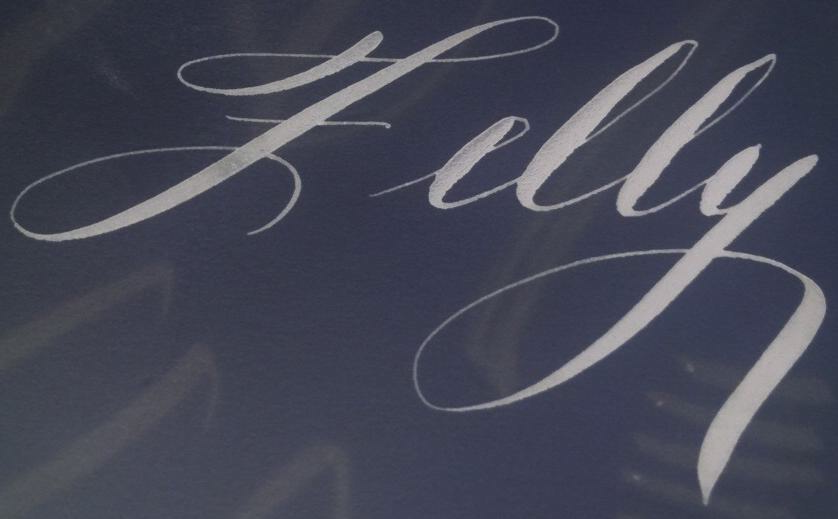

Recognized text:   'folly'


In [ ]:

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device for inference set to: {device}")

# Path to the Saved Model
MODEL_PATH_FOR_INFERENCE = os.path.join(DRIVE_SAVE_DIR, "best_model")

# check if the chosen model path exists
if not os.path.exists(MODEL_PATH_FOR_INFERENCE):
    print(f"ERROR: Model for inference not found at {MODEL_PATH_FOR_INFERENCE}")
    print("Please ensure training completed and a model was saved, or update the path.")

    loaded_model_for_inference = None
    loaded_processor_for_inference = None
else:
    print(f"Loading fine-tuned model and processor from: {MODEL_PATH_FOR_INFERENCE}")
    try:
        loaded_model_for_inference = VisionEncoderDecoderModel.from_pretrained(MODEL_PATH_FOR_INFERENCE).to(device)
        loaded_processor_for_inference = TrOCRProcessor.from_pretrained(MODEL_PATH_FOR_INFERENCE)
        loaded_model_for_inference.eval()
        print("Model and processor for inference loaded successfully.")
    except Exception as e:
        print(f"Error loading model/processor for inference: {e}")
        loaded_model_for_inference = None
        loaded_processor_for_inference = None

# Inference Function
def recognize_handwritten_text(image_input, model, processor_inf):

    if model is None or processor_inf is None:
        print("Error: Model or processor for inference is not available.")
        return None

    try:
        if isinstance(image_input, str):
            if not os.path.exists(image_input):
                print(f"Error: Image path does not exist: {image_input}")
                return None
            image = Image.open(image_input).convert("RGB")
        elif isinstance(image_input, PIL_Image.Image):
            image = image_input.convert("RGB")
        else:
            print("Error: Invalid image_input type. Must be a file path or PIL Image object.")
            return None
    except Exception as e:
        print(f"Error loading or converting image: {e}")
        return None

    # Preprocess the image
    try:
        pixel_values = processor_inf(images=image, return_tensors="pt").pixel_values.to(device)
    except Exception as e:
        print(f"Error during image preprocessing: {e}")
        return None


    with torch.no_grad():
        try:
            generated_ids = model.generate(pixel_values)
        except Exception as e:
            print(f"Error during text generation: {e}")
            return None

    # Decode the generated ID to text
    try:
        generated_text = processor_inf.batch_decode(generated_ids, skip_special_tokens=True)[0]
    except Exception as e:
        print(f"Error during text decoding: {e}")
        return None

    return generated_text

print("\nInference function 'recognize_handwritten_text' defined.")

if 'test_df' in locals() and not test_df.empty and loaded_model_for_inference is not None:
    sample_idx_for_inference = 0
    if len(test_df) > sample_idx_for_inference:
        test_image_path = test_df['image_path'][sample_idx_for_inference]
        ground_truth_text = test_df['text'][sample_idx_for_inference]

        print(f"\n Example Inference on a Test Image ")
        print(f"Test image path: {test_image_path}")
        print(f"Ground truth text: '{ground_truth_text}'")

        # Display the image
        try:
            display_image = Image.open(test_image_path)
            print("Displaying test image (if in a suitable environment like Colab):")
            from IPython.display import display
            display(display_image)
        except Exception as e:
            print(f"Could not display image: {e}")

        # Perform recognition
        recognized_text = recognize_handwritten_text(
            image_input=test_image_path,
            model=loaded_model_for_inference,
            processor_inf=loaded_processor_for_inference
        )

        if recognized_text is not None:
            print(f"Recognized text:   '{recognized_text}'")
        else:
            print("Inference failed for the sample image.")
    else:
        print("\nTest DataFrame is smaller than sample_idx_for_inference. Cannot run example.")

elif loaded_model_for_inference is None:
    print("\nSkipping inference example because the model for inference was not loaded.")
else:
    print("\nTest DataFrame ('test_df') is not defined or empty. Cannot run inference example on test image.")
    print("You can test the function by providing a path to any other handwritten image PNG/JPG.")
    # Example with a placeholder path (replace with an actual image path on your Drive):
    # placeholder_image_path = "/content/drive/MyDrive/your_test_image.png"
    # if os.path.exists(placeholder_image_path) and loaded_model_for_inference:
    #     recognized_text = recognize_handwritten_text(placeholder_image_path, loaded_model_for_inference, loaded_processor_for_inference)
    #     if recognized_text:
    #         print(f"\nRecognized text from '{placeholder_image_path}': '{recognized_text}'")


Recognition result for '/content/drive/MyDrive/testing_the_model/321.png':


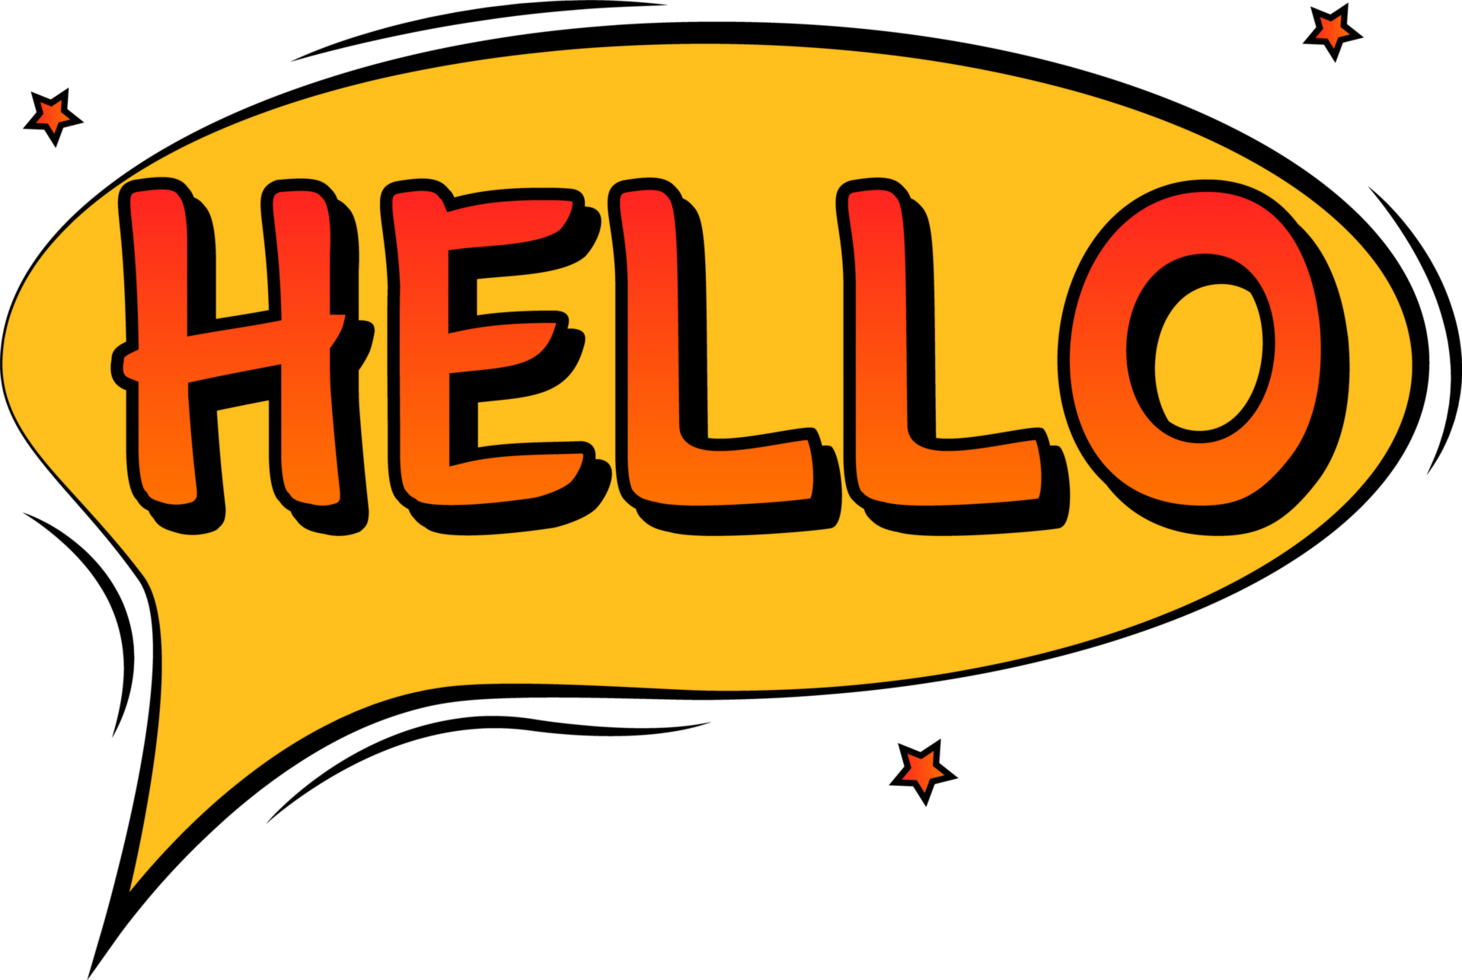

  Recognized: 'HELLO'


In [ ]:
if loaded_model_for_inference and loaded_processor_for_inference:
    my_image_path = "/content/drive/MyDrive/testing_the_model/321.png"
    if os.path.exists(my_image_path):
        custom_recognized_text = recognize_handwritten_text(my_image_path, loaded_model_for_inference, loaded_processor_for_inference)
        if custom_recognized_text:
            print(f"\nRecognition result for '{my_image_path}':")

            from IPython.display import display
            display(Image.open(my_image_path))
            print(f"  Recognized: '{custom_recognized_text}'")
    else:
        print(f"Your custom image path not found: {my_image_path}")
else:
    print("Model/processor for inference not loaded. Cannot run custom image test.")

In [ ]:
DRIVE_SAVE_DIR = "/content/drive/MyDrive/Colab_Checkpoints/TrOCR_Imgur5K_Sample_FineTuning"

Using already loaded model and processor for inference.

Inference function 'recognize_handwritten_text' (accepts path/URL) defined.

--- Example 1: Inference on a Local Test Image (from test_df) ---
Test DataFrame ('test_df') is not defined or empty. Cannot run example 1 for local image.

--- Example 2: Inference on an Image URL (User Provided) ---
Enter the URL of a handwritten image (or press Enter to skip): https://cdn.textstudio.com/output/sample/normal/9/5/7/5/student-logo-73-5759.png

Attempting to load and display image from URL: https://cdn.textstudio.com/output/sample/normal/9/5/7/5/student-logo-73-5759.png
Image downloaded from URL. Displaying now:


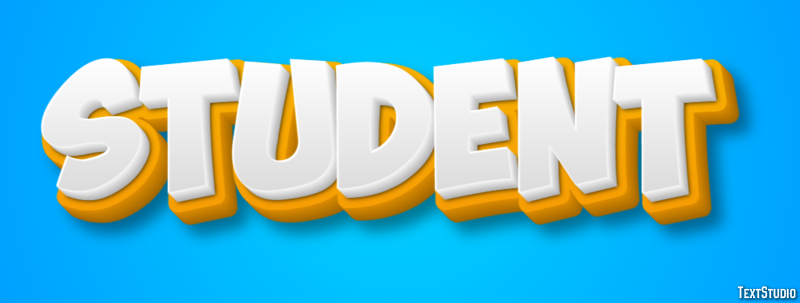


Performing OCR on the displayed image...
Recognized text from URL: 'STODENT'


In [ ]:
# image to text - accepts path or url

from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import os
import requests
import io # handling image data from URL
from IPython.display import display, clear_output

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device for inference set to: {device}")


MODEL_PATH_FOR_INFERENCE = os.path.join(DRIVE_SAVE_DIR, "best_model")

if 'loaded_model_for_inference' not in globals() or \
   'loaded_processor_for_inference' not in globals() or \
   loaded_model_for_inference is None or \
   loaded_processor_for_inference is None:

    if not os.path.exists(MODEL_PATH_FOR_INFERENCE):
        print(f"ERROR: Model for inference not found at {MODEL_PATH_FOR_INFERENCE}")
        loaded_model_for_inference = None
        loaded_processor_for_inference = None
    else:
        print(f"Loading fine-tuned model and processor from: {MODEL_PATH_FOR_INFERENCE}")
        try:
            loaded_model_for_inference = VisionEncoderDecoderModel.from_pretrained(MODEL_PATH_FOR_INFERENCE).to(device)
            loaded_processor_for_inference = TrOCRProcessor.from_pretrained(MODEL_PATH_FOR_INFERENCE)
            loaded_model_for_inference.eval()
            print("Model and processor for inference loaded successfully.")
        except Exception as e:
            print(f"Error loading model/processor for inference: {e}")
            loaded_model_for_inference = None
            loaded_processor_for_inference = None
else:
    print("Using already loaded model and processor for inference.")


def recognize_handwritten_text(image_input, model, processor_inf):
    if model is None or processor_inf is None:
        print("Error: Model or processor for inference is not available.")
        return None, None

    pil_image = None
    try:
        if isinstance(image_input, str):
            if image_input.startswith("http://") or image_input.startswith("https://"):
                print(f"Downloading image from URL: {image_input}")
                headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
                response = requests.get(image_input, headers=headers, timeout=15, stream=True)
                response.raise_for_status()
                image_bytes = io.BytesIO(response.content)
                pil_image = Image.open(image_bytes).convert("RGB")
                print("Image downloaded and loaded successfully.")
            elif os.path.exists(image_input):
                pil_image = Image.open(image_input).convert("RGB")
            else:
                print(f"Error: Image path does not exist or URL is invalid: {image_input}")
                return None, None
        elif isinstance(image_input, Image.Image):
            pil_image = image_input.convert("RGB")
        else:
            print("Error: Invalid image_input type. Must be a file path, URL, or PIL Image object.")
            return None, None
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from URL: {e}")
        return None, None
    except FileNotFoundError:
        print(f"Error: Image file not found at path: {image_input}")
        return None, None
    except Exception as e:
        print(f"Error loading or converting image: {e}")
        return None, None

    if pil_image is None:
        print("Error: Could not obtain PIL image from input.")
        return None, None

    try:
        pixel_values = processor_inf(images=pil_image, return_tensors="pt").pixel_values.to(device)
    except Exception as e:
        print(f"Error during image preprocessing: {e}")
        return None, pil_image

    with torch.no_grad():
        try:
            generated_ids = model.generate(pixel_values)
        except Exception as e:
            print(f"Error during text generation: {e}")
            return None, pil_image

    try:
        generated_text = processor_inf.batch_decode(generated_ids, skip_special_tokens=True)[0]
    except Exception as e:
        print(f"Error during text decoding: {e}")
        return None, pil_image

    return generated_text, pil_image

print("\nInference function 'recognize_handwritten_text' (accepts path/URL) defined.")


if loaded_model_for_inference is not None and loaded_processor_for_inference is not None:

    print("\n--- Example 1: Inference on a Local Test Image (from test_df) ---")
    if 'test_df' in locals() and not test_df.empty:
        sample_idx_for_inference = 0
        if len(test_df) > sample_idx_for_inference:
            test_image_path = test_df['image_path'][sample_idx_for_inference]
            ground_truth_text = test_df['text'][sample_idx_for_inference]

            print(f"Test image path: {test_image_path}")
            print(f"Ground truth text: '{ground_truth_text}'")

            recognized_text, processed_image = recognize_handwritten_text(
                image_input=test_image_path,
                model=loaded_model_for_inference,
                processor_inf=loaded_processor_for_inference
            )

            if processed_image:
                try:
                    print("Displaying test image:")
                    display(processed_image)
                except Exception as e:
                    print(f"Could not display image: {e}")

            if recognized_text is not None:
                print(f"Recognized text:   '{recognized_text}'")
            else:
                print("OCR prediction failed for the local sample image.")
        else:
            print("Test DataFrame is smaller than sample_idx_for_inference. Cannot run example 1.")
    else:
        print("Test DataFrame ('test_df') is not defined or empty. Cannot run example 1 for local image.")

    print("\n--- Example 2: Inference on an Image URL (User Provided) ---")
    try:
        user_image_url = input("Enter the URL of a handwritten image (or press Enter to skip): ").strip()

        if user_image_url:
            print(f"\nAttempting to load and display image from URL: {user_image_url}")

            # download and display image from url
            downloaded_pil_image_from_url = None
            try:
                headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
                response = requests.get(user_image_url, headers=headers, timeout=15, stream=True)
                response.raise_for_status()
                image_bytes = io.BytesIO(response.content)
                downloaded_pil_image_from_url = Image.open(image_bytes).convert("RGB")

                print("Image downloaded from URL. Displaying now:")
                display(downloaded_pil_image_from_url)

            except requests.exceptions.RequestException as e_req:
                print(f"Error downloading image from URL: {e_req}")
            except Exception as e_img_load:
                print(f"Error loading image from downloaded data: {e_img_load}")

            # perform ocr on the downloaded image
            if downloaded_pil_image_from_url:
                print("\nPerforming OCR on the displayed image...")
                recognized_text_url, _ = recognize_handwritten_text(
                    image_input=downloaded_pil_image_from_url,
                    model=loaded_model_for_inference,
                    processor_inf=loaded_processor_for_inference
                )

                if recognized_text_url is not None:
                    print(f"Recognized text from URL: '{recognized_text_url}'")
                else:
                    print(f"OCR prediction failed for the image from URL: {user_image_url}")
            else:
                print("Skipping OCR because image could not be downloaded or loaded from URL.")
        else:
            print("No URL entered, skipping URL inference example.")

    except Exception as e_input_main:
        print(f"An error occurred during the URL input/processing main block: {e_input_main}")

else:
    print("\nSkipping inference examples because the model/processor for inference was not loaded.")